# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [1]:
import pandas as pd
import numpy as np
import os
import urllib.request
import plotly.express as px

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import scipy as sp
import scipy.stats
from numpy.random import RandomState

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Функция загрузки датасетов из сети

def get_file(file_name, url):
    print(file_name, 'Загружаем файл...')
    _ = urllib.request.urlretrieve(url, file_name)

        
urls = {
    'train': ('gold_recovery_train.csv', 'https://code.s3.yandex.net/datasets/gold_recovery_train.csv'),
    'test': ('gold_recovery_test.csv', 'https://code.s3.yandex.net/datasets/gold_recovery_test.csv'),
    'full': ('gold_recovery_full.csv', 'https://code.s3.yandex.net/datasets/gold_recovery_full.csv')
}

[get_file(*urls[k]) for k in urls]

gold_recovery_train.csv Загружаем файл...
gold_recovery_test.csv Загружаем файл...
gold_recovery_full.csv Загружаем файл...


[None, None, None]

In [3]:
df_full = pd.read_csv(urls['full'][0])
df_full.info()
df_full.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
df_train = pd.read_csv(urls['train'][0])
df_train.info()
df_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
df_test = pd.read_csv(urls['test'][0])
df_test.info()
df_test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


# 1. Подготовка данных

### 1.1 Проверим, что эффективность расчитана правильно

Для ручного расчета будем использовать следующие столбцы: 
rougher.output.recovery (черновой концентрат):

C = rougher.output.concentrate_au

F = rougher.input.feed_au

T = rougher.output.tail_au

final.output.recovery (итоговый концентрат):

C = final.output.concentrate_au

F = rougher.input.feed_au

T = final.output.tail_au

In [6]:
# для простоты создадим отдельный датасет только из нужных столбцов, переименуем их и удалим все пропуски 

test_rougher = df_train.filter(['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au','rougher.output.tail_au'], axis = 1)
test_final = df_train.filter(['final.output.recovery', 'final.output.concentrate_au', 'rougher.input.feed_au', 'final.output.tail_au'], axis = 1)

test_rougher.columns = ['recovery', 'c', 'f', 't']
test_final.columns = ['recovery', 'c', 'f', 't']

test_rougher = test_rougher.dropna()
test_final = test_final.dropna()



In [7]:
#посмотрим, что у нас вышло 

test_rougher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   recovery  14287 non-null  float64
 1   c         14287 non-null  float64
 2   f         14287 non-null  float64
 3   t         14287 non-null  float64
dtypes: float64(4)
memory usage: 558.1 KB


In [8]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15339 entries, 0 to 16859
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   recovery  15339 non-null  float64
 1   c         15339 non-null  float64
 2   f         15339 non-null  float64
 3   t         15339 non-null  float64
dtypes: float64(4)
memory usage: 599.2 KB


Прекрасно, все готово для проверки.

In [9]:
def rec(data):
    recovery_check = (data['c'] * (data['f'] - data['t']))*100/(data['f'] * (data['c'] - data['t']))
    error = mean_absolute_error(data['recovery'], recovery_check)
    print(error)
    
rec(test_rougher)
rec(test_final)

1.0898633667227423e-14
9.234385318911162e-15


Результаты сильного доверия не вселяют. Вероятно, где-то была допущена ошибка при расчетах. Однако, в случае с rougher, ошибка не так велика, но даже 16% могут привести к упущенной выгоде. Предлагаю учитывать далее как расчетный параметр, так и данный. 

Проведем проверку еще раз после предобработки данных.

### 1.2 Проанализируем признаки, недоступные в тестовой выборке

В тестовой выборке на 30 колонок меньше, чем в полной и тренировочной. Это признаки которые мы получаем в процессе очистки, которые не доступны на старте, поэтому в модели их использовать не получится, т.е. в тренировочных данных стоит оставить только те признаки, которые есть в тестовых.

Отсутствуют показатели этапа final и отсутсвуют типы параметра output. Вероятно, если бы они были известны в реальном времени, не было бы и этого проекта, потому что было бы просто из них считать необходимые характеристики. 

In [10]:
test_columns = df_test.columns
df_train = df_train[test_columns]
df_train = pd.merge(df_train, df_full[['date', 'final.output.recovery', 'rougher.output.recovery']], on='date') #добавим целевые признаки по дате из общего датасета
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16860 entries, 0 to 16859
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        16860 non-null  object 
 1   primary_cleaner.input.sulfate               15553 non-null  float64
 2   primary_cleaner.input.depressant            15598 non-null  float64
 3   primary_cleaner.input.feed_size             16860 non-null  float64
 4   primary_cleaner.input.xanthate              15875 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      16820 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    16827 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      16820 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    16833 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      16822 non-null  float64
 10  primary_cl

### 1.3 Проведем предобработку данных

С первого взгляда видно, что в каждом столбце всех выборок разное количество ненулевых значений. Меньше всего пользы нам принесут данные, у которых пропущенные целевые признаки final.output.recovery и rougher.output.recovery. Предлагаю избавиться от него в тренировочной выборке. 

In [11]:
df_train = df_train.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'])

In [12]:
print(df_train['final.output.recovery'].isna().sum())
print(df_train['rougher.output.recovery'].isna().sum())

0
0


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   primary_cleaner.input.sulfate               14129 non-null  float64
 2   primary_cleaner.input.depressant            14117 non-null  float64
 3   primary_cleaner.input.feed_size             14149 non-null  float64
 4   primary_cleaner.input.xanthate              14049 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      14147 non-null  float64
 10  primary_cl

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Мы видим, что как в тренировочной, так и в тестовой выборке все еще есть пропущенные значения. 

В тестовой удалим пустые значения, чтобы сделать данные наиболее чистыми. 
В тренировочной заменим пустые значения предыдущими по дате, так как в задании было сказано, что соседние по времени параметры часто похожи.

In [15]:
# тестовая выборка
df_test = df_test.dropna()

#тренровочная выборка 
df_train = df_train.sort_values(by = 'date')
df_train = df_train.fillna(method='ffill')

Интересно, что мы не можем в новых данных добавить расчетный параметр recover, так как удалили столбцы с индексами final и output. Поэтому придется полагаться на не очень точный расчетный параметр и иметь ввиду, что такова жизнь. 

### Вывод ###

На выходе мы имеем нетронутый исходный датасет для проверки значений и вычислений по индексу даты. 
И наиболее приближенный по структуре тестовых данных тренировочные данные.

# 2. Анализ данных

### 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

Для начала найдем необходимые столбцы, часть из них отсутсвует, так что будем работать с общей выборкой, только удалим дубликаты: 

<Br><br>
<table width=1000 style="margin-top:10px; margin-left:10px;">
    <tr><td></td>
        <td>Au</td>
        <td>Ag</td>
        <td>Pb</td>
    </tr>
    <tr><td>rougher</td>
        <td>rougher.output.concentrate_au</td>
        <td>rougher.output.concentrate_ag</td>
        <td>rougher.output.concentrate_pb</td>
    </tr>
    <tr><td>primary_cleaner</td>
        <td>primary_cleaner.output.concentrate_au</td>
        <td>primary_cleaner.output.concentrate_ag</td>
        <td>primary_cleaner.output.concentrate_pb</td>
    </tr>
    <tr><td>final</td>
        <td>final.output.concentrate_au</td>
        <td>final.output.concentrate_ag</td>
        <td>final.output.concentrate_pb</td>   
    </tr>
</table>
<br><br>


Видимо, на втором этапе очистки уходят хвосты, а концентрация металла не меняется.

In [16]:
# Создадим для удобства временный датасет из нужных нам данных. 
    
concentrate_au = df_full.filter(['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'], axis = 1)
concentrate_ag = df_full.filter(['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'], axis = 1)
concentrate_pb = df_full.filter(['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'], axis = 1)

concentrate_pb = concentrate_pb.dropna()
concentrate_au = concentrate_au.dropna()
concentrate_ag = concentrate_ag.dropna()

concentrate_au.head()


,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
0,19.793808,34.174427,42.192020
1,20.050975,34.118526,42.701629
2,19.737170,33.969464,42.657501
3,19.320810,28.260743,42.689819
4,19.216101,33.044932,42.774141


<AxesSubplot:ylabel='final.output.concentrate_au'>

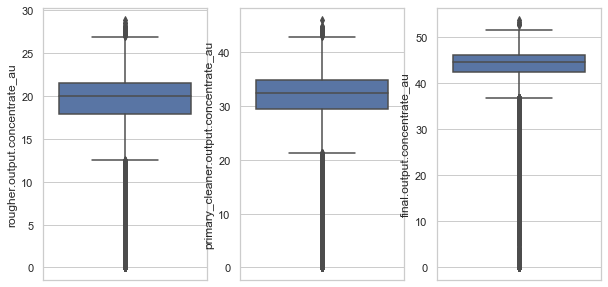

In [17]:
#посмотрим графики изменения концентрации AU
sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 3)
sns.boxplot(   y= "rougher.output.concentrate_au", data=concentrate_au,  orient='h' , ax=axes[0])
sns.boxplot(   y= "primary_cleaner.output.concentrate_au", data=concentrate_au,  orient='h' , ax=axes[1])
sns.boxplot(   y= "final.output.concentrate_au", data=concentrate_au,  orient='h' , ax=axes[2])

<AxesSubplot:ylabel='final.output.concentrate_ag'>

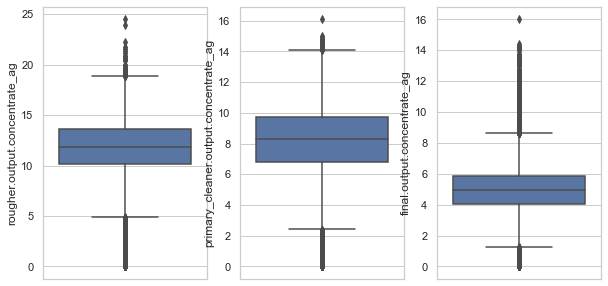

In [18]:
#посмотрим графики изменения концентрации AU
sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 3)
sns.boxplot(   y= "rougher.output.concentrate_ag", data=concentrate_ag,  orient='h' , ax=axes[0])
sns.boxplot(   y= "primary_cleaner.output.concentrate_ag", data=concentrate_ag,  orient='h' , ax=axes[1])
sns.boxplot(   y= "final.output.concentrate_ag", data=concentrate_ag,  orient='h' , ax=axes[2])

<AxesSubplot:ylabel='final.output.concentrate_pb'>

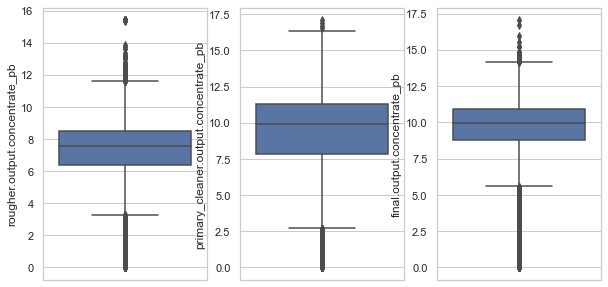

In [19]:
#посмотрим графики изменения концентрации AU
sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 3)
sns.boxplot(   y= "rougher.output.concentrate_pb", data=concentrate_pb,  orient='h' , ax=axes[0])
sns.boxplot(   y= "primary_cleaner.output.concentrate_pb", data=concentrate_pb,  orient='h' , ax=axes[1])
sns.boxplot(   y= "final.output.concentrate_pb", data=concentrate_pb,  orient='h' , ax=axes[2])

### Вывод ###

Золото: Мы видим, что медианная концентрация золота в руде повышается по этапам с 20% до 45%, в то же время сокращаются и квантили, что говорит о том, что много точек распределены очень близко к медианному значению. Но в то де время есть огромное количество выбросов, которые тянутся до нулевых значений. 

Серебро: Концентрация серебра снижается с 12% до 5%. При этом даже выбросы лежат ниже 16%. Это говорит о том, что серебро вымывают достаточно эффективно. 

Свинец: Интересно, но концентрация свинца повышается по этапам. Видимо его не вымывают, а делают с ним что-то вне существующих этвпов очистки, либо очищают от свинца неэффективно и его объемы падают с меньшей скоросью, чем растет объем золота. 

### 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

In [20]:
# вычленим необходимые нам столбцы для простоты 

size_train = df_train.filter(['rougher.input.feed_size', 'primary_cleaner.input.feed_size'], axis = 1)
size_test = df_test.filter(['rougher.input.feed_size', 'primary_cleaner.input.feed_size'], axis = 1)

size_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   rougher.input.feed_size          14149 non-null  float64
 1   primary_cleaner.input.feed_size  14149 non-null  float64
dtypes: float64(2)
memory usage: 331.6 KB


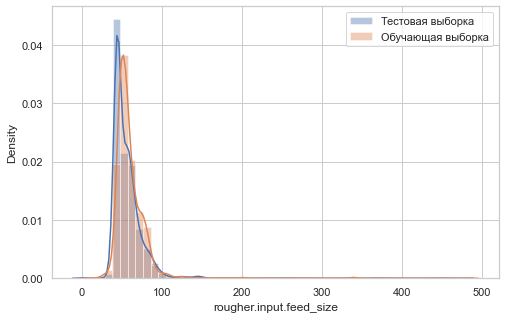

In [21]:
# посмотрим распределение

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.distplot(df_test['rougher.input.feed_size'], label='Тестовая выборка')
sns.distplot(df_train['rougher.input.feed_size'], label='Обучающая выборка')
plt.legend()

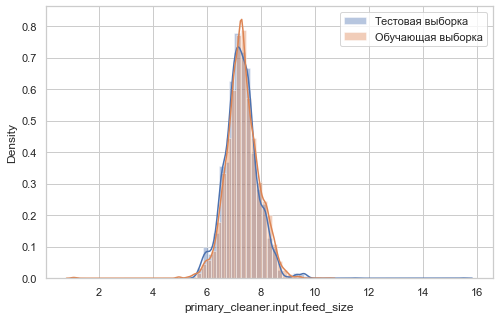

In [22]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.distplot(df_test['primary_cleaner.input.feed_size'], label='Тестовая выборка')
sns.distplot(df_train['primary_cleaner.input.feed_size'], label='Обучающая выборка')
plt.legend()

Вывод: 

В случае с флотацией, распределения довольно похожи, и лежат в одном и том же интервале. Только у тренировочной выборки немного большее смещение влево. Пожалуй, выборку менять не стоит. 

У первого этапа очистки в тренировочной и тестовой распределения так же схожи и находятся в интервале 5-9, однако в тестовой выборке более тяжелый хвост и есть выбросы, которые сдвигают график влево. Их стоит почистить. 

### 2.3 Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

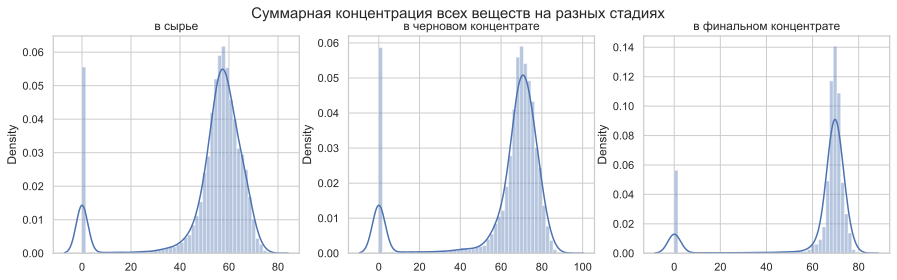

In [23]:
concentration_stages = [('rougher.input.feed_', 'в сырье'),
                        ('rougher.output.concentrate_', 'в черновом концентрате'), 
                        ('final.output.concentrate_', 'в финальном концентрате')]


fig, axs = plt.subplots(1, len(concentration_stages), figsize=(15, 4))
fig.suptitle('Суммарная концентрация всех веществ на разных стадиях', fontsize=15)


for stage, ax in zip(concentration_stages, axs):
    ax.set_title(stage[1])
    full_sum =  df_full[stage[0]+ 'ag'] + df_full[stage[0]+ 'au'] + df_full[stage[0]+ 'pb'] + df_full[stage[0]+ 'sol']
    
    sns.distplot(full_sum, ax=ax)   

plt.show()

Хорошо видно, что у каждого показателя сильно выделяются нули. Они и являются выбросами, поэтому, чтобы ограничить данные снизу, исключим эти показатели в столбцах, которые есть в обучающей и тестовой выборке.

In [24]:
df_train = df_train.replace(0, np.nan)
df_train = df_train.dropna(how='all', subset=['rougher.input.feed_au', 'rougher.input.feed_ag', 
                                             'rougher.input.feed_pb','rougher.input.feed_sol'])
df_train = df_train.dropna()

In [25]:
# так же из предыдущего пункта мы собирались удалить выбросы в распределении размеров гранул сырья в тестовой выборке. 
#Удалим значения больше 10

df_test = df_test.drop(df_test[df_test['primary_cleaner.input.feed_size'] > 10].index)
df_test['primary_cleaner.input.feed_size'].describe()

count    5381.000000
mean        7.266360
std         0.597409
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max         9.770000
Name: primary_cleaner.input.feed_size, dtype: float64

In [26]:
print('В обучающей выборке : {} строк {} признаков'.format(df_train.shape[0],df_train.shape[1]))
print('В тестовой выборке: {} строк {} признаков'.format(df_test.shape[0], df_test.shape[1]))

В обучающей выборке : 13769 строк 55 признаков
В тестовой выборке: 5381 строк 53 признаков


### Вывод ###

Мы увидели, что в случае с концентрацией веществ, часты случаи выбросов в виде нулевой концентрации. Это скорее всего продиктовано ошибкой оборудования, так как прочие значения лежать намного правее нуля. Для того, чтобы в дальнейшем эти значения не портили статистику, мы их удалили. 


# 3. Модель

### 3.1. Напишем функцию для вычисления итоговой sMAPE.

In [27]:
def smape(t,p):    
    return 100/len(t) * np.sum(2 * np.abs(p - t) / (np.abs(t) + np.abs(p)))


### 3.2. Обучим разные модели и оценим их качество кросс-валидацией. 

In [28]:
# подготовим тестовую и тренировочную выборки 

state = RandomState(12345)

df_test = df_test.set_index(['date'])
df_full = df_full.set_index(['date'])
target_rougher = df_train['rougher.output.recovery']                          
target_final = df_train['final.output.recovery']
features_rougher = df_train.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
features_final = df_train.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)

X_train_rougher, X_valid_rougher, y_train_rougher, y_valid_rougher = train_test_split(features_rougher, target_rougher, test_size=0.2, random_state=state)
X_test_rougher = df_test
y_test_rougher = df_full.loc[X_test_rougher.index,'rougher.output.recovery']

X_train_final, X_valid_final, y_train_final, y_valid_final = train_test_split(features_final, target_final, test_size=0.2, random_state=state)                          
X_test_final = df_test
y_test_final = df_full.loc[X_test_final.index, 'final.output.recovery']

In [29]:
# Метрику smape подготовим для GridSearchCV

smape_score = make_scorer(smape, greater_is_better=False)

In [30]:
# Проведем кросс валидацию с помощью kFold и разделим на 5 частей

cv = KFold(n_splits=5, shuffle=False)

In [31]:
# Напишем pipeline для rf

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=state))
])

params_rf = [
    {
        'model__bootstrap': [True, False],
        'model__max_depth': [5, 10, 15],
        'model__max_features': ['auto', 'sqrt'],
        'model__min_samples_leaf': [2, 4],
        'model__min_samples_split': [2, 5],
        'model__n_estimators': [10, 100]
    }]

grid_rougher_rf = GridSearchCV(pipe_rf, param_grid=params_rf, cv=cv, n_jobs=-1, scoring=smape_score, verbose=1)
grid_rougher_rf.fit(X_train_rougher, y_train_rougher)

print('Best Params:', grid_rougher_rf.best_params_)

# Модель с лучшими параметрами для валидационной выборки Rougher

y_pred_rf = grid_rougher_rf.predict(X_valid_rougher)

smape_rougher_rf = smape(y_valid_rougher, y_pred_rf)
print('Smape:', smape_rougher_rf)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 29.7min finished


Best Params: {'model__bootstrap': False, 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Smape: 2.550888308109749


In [32]:
# Напишем pipeline для lasso

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', linear_model.Lasso(random_state=state))
])

params_lr = [
    {
        'model__alpha': np.linspace(0.01,1,10),
        'model__normalize': [True,False]
    }]

grid_rougher_lr = GridSearchCV(pipe_lr, param_grid=params_lr, cv=cv, n_jobs=-1, scoring=smape_score, verbose=1)
grid_rougher_lr.fit(X_train_rougher, y_train_rougher)

print('Best Params:', grid_rougher_lr.best_params_)

# Модель с лучшими параметрами для валидационной выборки Rougher

y_pred_lr = grid_rougher_lr.predict(X_valid_rougher)

smape_rougher_lr = smape(y_valid_rougher, y_pred_lr)
print('Smape:', smape_rougher_lr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s


Best Params: {'model__alpha': 0.01, 'model__normalize': False}
Smape: 4.630548426811384


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


In [33]:
# Напишем pipeline для gradient boosting

pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(random_state=state))
])

params_gb = [
    {
              'model__max_depth': [5, 6, 7],
              'model__subsample': [0.5, 0.7],
              'model__n_estimators': [10, 100]
    }]

grid_rougher_gb = GridSearchCV(pipe_gb, param_grid=params_gb, cv=cv, n_jobs=-1, scoring=smape_score, verbose=1)
grid_rougher_gb.fit(X_train_rougher, y_train_rougher)

print('Best Params:', grid_rougher_gb.best_params_)

# Модель с лучшими параметрами для валидационной выборки Rougher

y_pred_gb = grid_rougher_gb.predict(X_valid_rougher)

smape_rougher_gb = smape(y_valid_rougher, y_pred_gb)
print('Smape:', smape_rougher_gb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


Best Params: {'model__max_depth': 7, 'model__n_estimators': 100, 'model__subsample': 0.7}
Smape: 2.8736203384498387


Лучше всего себя показала модель случайного леса. Ее и возьмем для тестовой выборки rougher.

In [34]:
y_pred_rougher = grid_rougher_rf.predict(X_test_rougher)

smape_rougher = smape(y_test_rougher, y_pred_rougher)
smape_rougher

8.174173093864036

Теперь проделаем то же самое для выборки Final

In [35]:
# Напишем pipeline для rf

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=state))
])

params_rf = [
    {
        'model__bootstrap': [True, False],
        'model__max_depth': [5, 10, 15],
        'model__max_features': ['auto', 'sqrt'],
        'model__min_samples_leaf': [2, 4],
        'model__min_samples_split': [2, 5],
        'model__n_estimators': [10, 100]
    }]

grid_final_rf = GridSearchCV(pipe_rf, param_grid=params_rf, cv=cv, n_jobs=-1, scoring=smape_score, verbose=1)
grid_final_rf.fit(X_train_final, y_train_final)

print('Best Params:', grid_final_rf.best_params_)

y_pred_rf = grid_final_rf.predict(X_valid_final)

smape_final_rf = smape(y_valid_final, y_pred_rf)
print('Smape:', smape_final_rf)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 29.4min finished


Best Params: {'model__bootstrap': False, 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Smape: 5.576626043787124


In [36]:
# Напишем pipeline для lasso

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', linear_model.Lasso(random_state=state))
])

params_lr = [
    {
        'model__alpha': np.linspace(0.01,1,10),
        'model__normalize': [True,False]
    }]

grid_final_lr = GridSearchCV(pipe_lr, param_grid=params_lr, cv=cv, n_jobs=-1, scoring=smape_score, verbose=1)
grid_final_lr.fit(X_train_final, y_train_final)

print('Best Params:', grid_final_lr.best_params_)

y_pred_lr = grid_final_lr.predict(X_valid_final)

smape_final_lr = smape(y_valid_final, y_pred_lr)
print('Smape:', smape_final_lr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


Best Params: {'model__alpha': 0.01, 'model__normalize': False}
Smape: 7.9561715152706025


In [37]:
# Напишем pipeline для gradient boosting

pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(random_state=state))
])

params_gb = [
    {
              'model__max_depth': [5, 6, 7],
              'model__subsample': [0.5, 0.7],
              'model__n_estimators': [10, 100]
    }]

grid_final_gb = GridSearchCV(pipe_gb, param_grid=params_gb, cv=cv, n_jobs=-1, scoring=smape_score, verbose=1)
grid_final_gb.fit(X_train_final, y_train_final)

print('Best Params:', grid_final_gb.best_params_)

# Модель с лучшими параметрами для валидационной выборки Rougher

y_pred_gb = grid_final_gb.predict(X_valid_final)

smape_final_gb = smape(y_valid_final, y_pred_gb)
print('Smape:', smape_final_gb)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


Best Params: {'model__max_depth': 7, 'model__n_estimators': 100, 'model__subsample': 0.7}
Smape: 6.309618692777767


Лучше всего себя показала модель случайного леса.

In [38]:
y_pred_final = grid_final_rf.predict(X_test_final)

smape_final = smape(y_test_final, y_pred_final)
smape_final

9.063391204848879

In [39]:
final_smape = 0.25*smape_rougher + 0.75*smape_final
final_smape

8.841086677102668

### Общий Вывод:

- С помощью GridSearchCV подобрали наилучшую модель и наилучшие параметры. Модель случайного леса показала лучший результат.
- Рассчитали с ее помощью итоговый sMAPE : 10.11.